In [1]:
import os
import re
import zipfile
import kaggle
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import pydotplus
import graphviz
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, KBinsDiscretizer, LabelEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, classification_report,confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import plot_partial_dependence, partial_dependence
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
INPUT_LOCATION = r"C:\Users\jwang\Desktop\20datasets\INPUT\2.SpanishABtest"
OUTPUT_LOCATION = r"C:\Users\jwang\Desktop\20datasets\OUTPUT\2.SpanishABtest"
USERTABLE_LOCATION = os.path.join(INPUT_LOCATION, 'user_table.csv')
TESTTABLE_LOCATION = os.path.join(INPUT_LOCATION, 'test_table.csv')

# 1. Data Read-in and Exploration

In [3]:
df_usertable = pd.read_csv(USERTABLE_LOCATION)
df_testtable = pd.read_csv(TESTTABLE_LOCATION)
df = df_testtable.merge(df_usertable,on="user_id",how="left")
df.loc[df['country'].isnull(),'country']="N/A"
df['agebin'] = pd.qcut(df['age'], 10)
exploration_df = df.copy()
exploration_df

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country,agebin
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain,"(30.0, 33.0]"
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico,"(19.0, 21.0]"
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain,"(33.0, 37.0]"
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico,"(21.0, 23.0]"
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico,"(17.999, 19.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
453316,425010,2015-12-04,SEO,Web,ES,NaN,FireFox,0,0,M,50.0,Mexico,"(37.0, 70.0]"
453317,826793,2015-12-01,SEO,Mobile,ES,NaN,Android_App,0,1,F,20.0,Colombia,"(19.0, 21.0]"
453318,514870,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0,M,25.0,Spain,"(24.0, 26.0]"
453319,785224,2015-12-04,SEO,Mobile,ES,NaN,Android_App,0,1,M,21.0,Colombia,"(19.0, 21.0]"


In [4]:
for col in ['source','device','browser_language','ads_channel','browser','sex','country']:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(exploration_df[col].value_counts().head(10))

----------------------------------------source---------------------------------------- - 

Ads       181877
SEO       180610
Direct     90834
Name: source, dtype: int64

----------------------------------------device---------------------------------------- - 

Web       251565
Mobile    201756
Name: device, dtype: int64

----------------------------------------browser_language---------------------------------------- - 

ES       377547
EN        63137
Other     12637
Name: browser_language, dtype: int64

----------------------------------------ads_channel---------------------------------------- - 

Facebook    68425
Google      68180
Yahoo       27435
Bing        13689
Other        4148
Name: ads_channel, dtype: int64

----------------------------------------browser---------------------------------------- - 

Android_App    155135
Chrome         101929
IE              61715
Iphone_App      46621
Safari          41065
FireFox         40766
Opera            6090
Name: browser, dtype: int64

----------------------------------------sex---------------------------------------- - 

M    264485
F    188382
Name: sex, dtype: int64

----------------------------------------country---------------------------------------- - 

Mexico       128484
Colombia      54060
Spain         51782
Argentina     46733
Peru          33666
Venezuela     32054
Chile         19737
Ecuador       15895
Guatemala     15125
Bolivia       11124
Name: country, dtype: int64

In [5]:
exploration_df.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


## 1.1 Visualize the conversion ratio by experiment/control & Spain/non-Spain

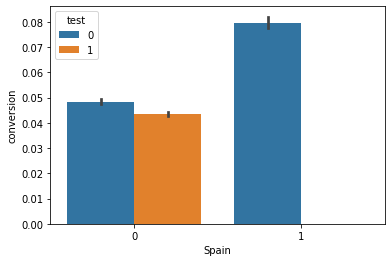

In [6]:
exploration_df['Spain'] = 1
exploration_df.loc[exploration_df['country']!='Spain','Spain']=0
sns.barplot(x='Spain',y="conversion",hue='test',data=exploration_df)

## 1.2 Sample t test on conversion ratio difference by experiment/control group

In [7]:
experiment_conversion = exploration_df.loc[(exploration_df['Spain']==0)&(exploration_df['test']==1),'conversion']
control_conversion = exploration_df.loc[(exploration_df['Spain']==0)&(exploration_df['test']==0),'conversion']
experiment_conversion_ratio = experiment_conversion.sum()/experiment_conversion.count()
control_conversion_ratio = control_conversion.sum()/control_conversion.count()
ttest_result = scipy.stats.ttest_ind(experiment_conversion,control_conversion)
p_val = ttest_result[1]
if p_val > 0.01:
    significant_diff = 'No'
else:
    significant_diff = 'Yes'
print('{0:<30s} {1:<30s}'.format('Group', 'Conversion Rate'))
print('-'*60)
print('{0:<30s} {1:<30.5f}'.format('Experiment', experiment_conversion_ratio))
print('{0:<30s} {1:<30.5f}'.format('Control', control_conversion_ratio))
print(' '*60)    
print('{0:<30s} {1:<30s}'.format('Significantly different (1%)', 'P-Value'))
print('-'*60)
print('{0:<30s} {1:<30.10f}'.format(significant_diff, p_val))

Group                          Conversion Rate               
------------------------------------------------------------
Experiment                     0.04342                       
Control                        0.04833                       
                                                            
Significantly different (1%)   P-Value                       
------------------------------------------------------------
Yes                            0.0000000000                  


## 1.3 Conversion rate by each variable

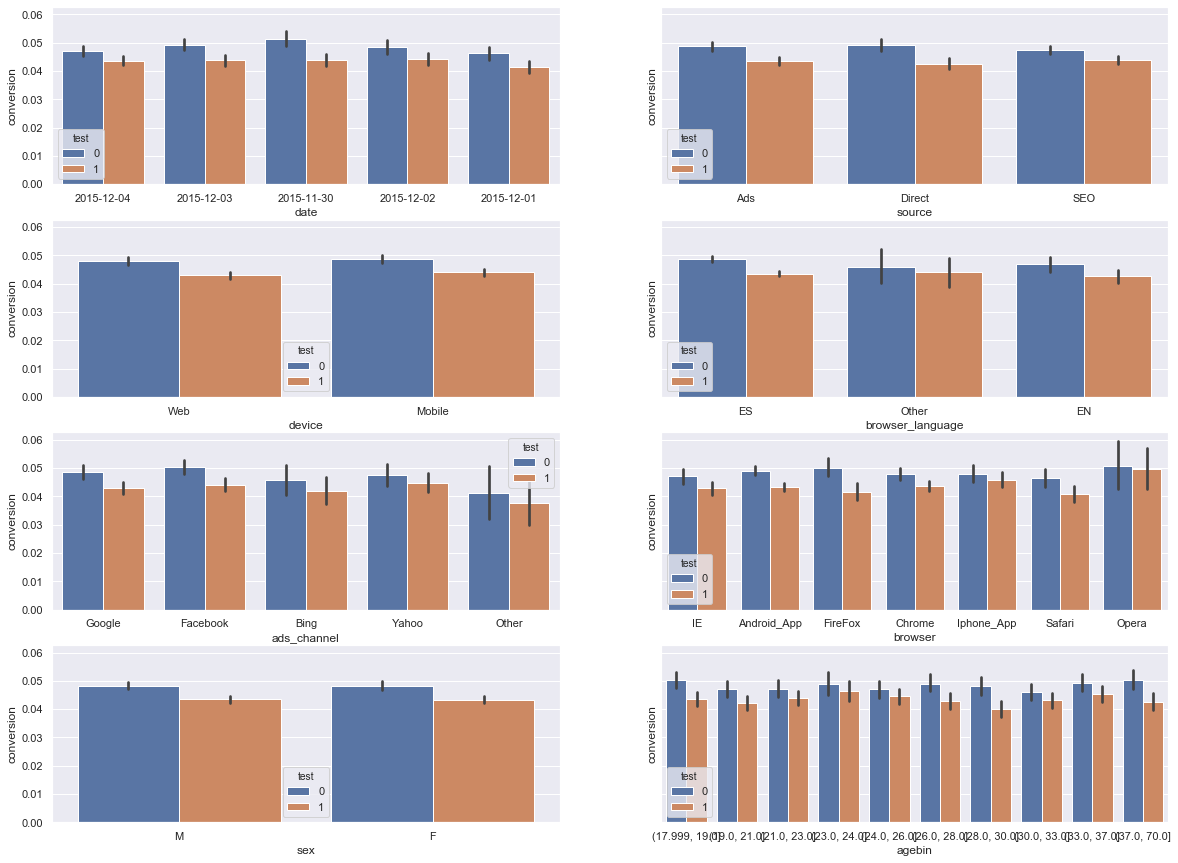

In [8]:
# Barplot with continuos variables into bins
sns.set()
fig,ax = plt.subplots(4,2, figsize=(20,15), sharey=True)
discrete_variables = ['date','source', 'device', 'browser_language','ads_channel', 'browser', 'sex','agebin']
for column in range(2):
    for row in range(4):
        index = column + row*2
        var = discrete_variables[index]
        sns.barplot(x=var,y= "conversion",hue="test", data=exploration_df[exploration_df['Spain']==0], ax=ax[row,column])

# 2. Explore negative results

## 2.1 Hypothesis test on random assigned experiment and control (in general)

In [9]:
total_count = exploration_df.loc[exploration_df['Spain']==0,'test'].count()
experiment_count = exploration_df.loc[(exploration_df['Spain']==0)&(exploration_df['test']==1),'test'].count()
experiment_percent = experiment_count / total_count
sample_sd = np.sqrt(0.5*0.5/total_count)
p_val_random = 2*(1-scipy.stats.norm(0.5,sample_sd).cdf(experiment_percent))
if p_val > 0.01:
    pass_ttest = 'True'
else:
    pass_ttest = 'False'
print('Experiment group consists of {:.1%} of non-Spain countries.'.format(experiment_percent))
print('')
print('{0:<30s} {1:<30s}'.format('Randomly Assigned? (1% level)', 'P-Value'))
print('-'*60)
print('{0:<30s} {1:<30.10f}'.format(pass_ttest, p_val_random))

Experiment group consists of 53.8% of non-Spain countries.

Randomly Assigned? (1% level)  P-Value                       
------------------------------------------------------------
False                          0.0000000000                  


## 2.2 Observe that some countries have positive effect in experiment group

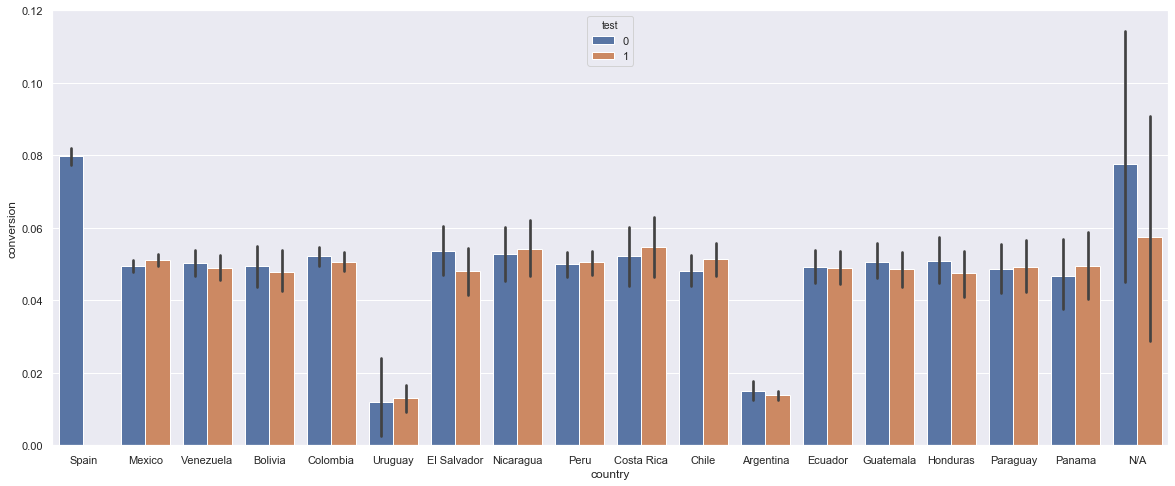

In [10]:
plt.subplots(figsize=(20,8))
sns.barplot(x='country',y="conversion",hue="test", data=exploration_df)

## 2.3 Hypothesis test on random assigned experiment and control (by country)

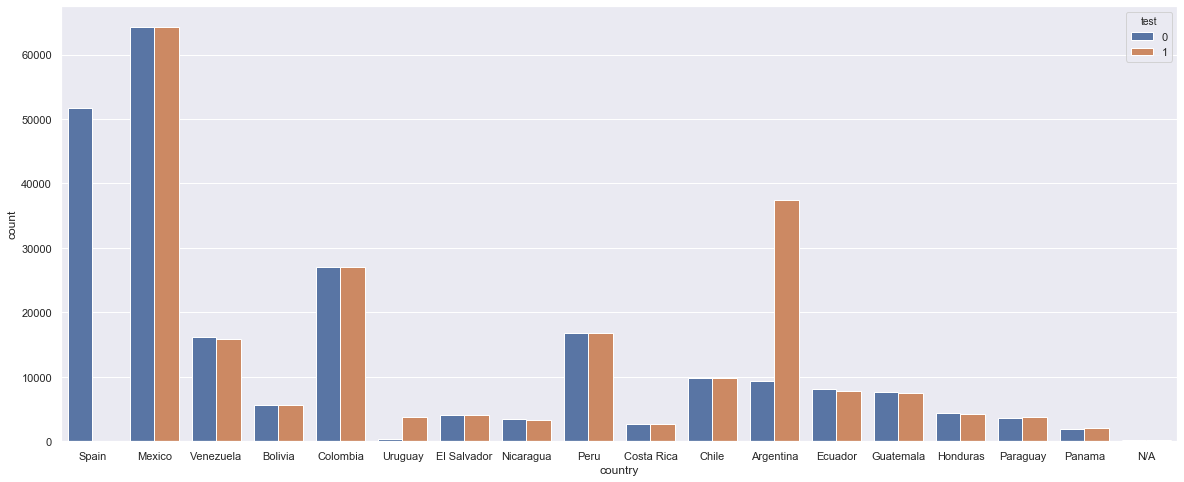

In [11]:
plt.subplots(figsize=(20,8))
sns.countplot(x='country',hue="test", data=exploration_df)

In [12]:
def test_random_by_var(varlist):
    '''
    Test the randomness of experiment-control split by variable excluding Spain.
    '''
    df_nonspain = exploration_df[exploration_df['Spain']==0]
    for var in varlist:
        print('{0:<15s}{1:<20s}{2:<15s}{3:<20s}{4:<30s}{5:<20s}'.format('Country', 
                                                           'Random (5% level)', 'P-Value',
                                                           'Positive Effect', 'Significantly different (5%)', 'P-Value' ))
        print('-' * 120)
        unique_value_list = df_nonspain[var].unique()
        random_test_df = pd.DataFrame()
        for value in unique_value_list:
            # Random assignment test
            total_count = df_nonspain.loc[df_nonspain[var]==value,'test'].count()
            experiment_count = df_nonspain.loc[(df_nonspain[var]==value)&(df_nonspain['test']==1),'test'].count()
            experiment_prob = experiment_count / total_count
            sample_sd = np.sqrt(0.5*0.5/total_count)
            if experiment_prob > 0.5:
                p_val = 2*(1-scipy.stats.norm(0.5,sample_sd).cdf(experiment_prob))
            else:
                p_val = 2*(1-scipy.stats.norm(0.5,sample_sd).cdf(1-experiment_prob))
            if p_val < 0.05:
                result = "No"
            else:
                result="Yes"
            # Conversion rate difference test
            experiment_conversion = df_nonspain.loc[(df_nonspain[var]==value)&(df_nonspain['test']==1),'conversion']
            control_conversion = df_nonspain.loc[(df_nonspain[var]==value)&(df_nonspain['test']==0),'conversion']
            experiment_conversion_ratio = experiment_conversion.sum()/experiment_conversion.count()
            control_conversion_ratio = control_conversion.sum()/control_conversion.count()
            ttest_result = scipy.stats.ttest_ind(experiment_conversion,control_conversion)
            p_val_ttest = ttest_result[1]
            if experiment_conversion_ratio > control_conversion_ratio:
                positive_effect = 'Yes'
            else:
                positive_effect = 'No'
            if p_val_ttest > 0.01:
                significant_diff = 'No'
            else:
                significant_diff = 'Yes'
            print('{0:<15s}{1:<20s}{2:<15.5f}{3:<20s}{4:<30s}{5:<20.5f}'.format(value,
                                                                                  result,p_val,
                                                                                  positive_effect,significant_diff,p_val_ttest))
                
test_random_by_var(['country'])

Country        Random (5% level)   P-Value        Positive Effect     Significantly different (5%)  P-Value             
------------------------------------------------------------------------------------------------------------------------
Mexico         Yes                 0.85391        Yes                 No                            0.16555             
Venezuela      Yes                 0.17293        No                  No                            0.57374             
Bolivia        Yes                 0.81999        No                  No                            0.71888             
Colombia       Yes                 0.61784        No                  No                            0.42373             
Uruguay        No                  0.00000        Yes                 No                            0.88281             
El Salvador    Yes                 0.65022        No                  No                            0.24825             
Nicaragua      Yes              

# 3. Conclusion
1. The result suggest that the experiment is negative in general, but positive for some countries.
2. The experiment is not set up correctly because the experiment and control groups are not assigned randomly for Uruguay and Argentina. 
